In [43]:
!git clone https://github.com/Google-Health/imaging-research.git
!pip install imaging-research/cxr-foundation/
from cxr_foundation.mimic import parse_embedding_file_pattern
from cxr_foundation import embeddings_data

fatal: destination path 'imaging-research' already exists and is not an empty directory.


Processing d:\vector_embedding\mimic_cxr_emb\imaging-research\cxr-foundation
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tensorflow_text-2.10.0-cp310-cp310-win_amd64.whl.metadata (2.1 kB)
  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tf_keras-2.15.0-py3-none-any.whl.metadata (1.6 kB)
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow_text-2.9.0-cp310-cp310-win_amd64.whl.metadata (2.1 kB)
  Using cached tensorflow_text-2.8.2-cp310-cp310-win_amd64.whl.metadata (2.1 kB)
  Using cached tensorflow_text-2.8.1-cp310-cp310-win_amd64.whl.metadata (2.0 kB)

The conflict is caused by:
    cxr-foundation 1.0.0 depends on tensorflow>=2.13.0
    tensorflow-text 2.10.0 depends on tensorflow<2.11 and >=2.10.0; platform_machine != "arm64" or platform_system != "

ERROR: Cannot install cxr-foundation and cxr-foundation==1.0.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\gebre\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [44]:
import pandas as pd
from IPython.display import clear_output
import io
import os
import glob
import zipfile
import shutil

import numpy as np
import random as python_random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sklm
from sklearn.utils import shuffle

seed=19
np.random.seed(seed)
python_random.seed(seed)

In [45]:
base_path="D:/Vector_Embedding/MIMIC_CXR_EMB"

In [46]:
# path to the zip file
zip_file_path = base_path+"/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0.zip"

# folder we want to extract the contents
extraction_folder = base_path+"/Extracted_Embeddings/"

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_folder)

print("Extraction complete.")

Extraction complete.


In [47]:
df_embeddings = pd.read_csv(base_path+"/Extracted_Embeddings/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/SHA256SUMS.txt",
                            delimiter=" ", header=None,
                            skiprows=[0])
display(df_embeddings.head(1))

,0,1
0,70e8c87d38d5dfba586218ccafb7428f76a3c7b08f6179...,files/p10/p10000032/s50414267/02aa804e-bde0afd...


In [48]:
SOURCE_COL_NAME = "embeddings_file"
# Create additional columns from file path components
df_embeddings = df_embeddings[[1]]
df_embeddings.rename(columns={1: "embeddings_file"}, inplace=True)
df_embeddings[["subject_id","study_id", "dicom_id"]] = df_embeddings.apply(
    lambda x: parse_embedding_file_pattern(x[SOURCE_COL_NAME]), axis=1, result_type="expand")
df_embeddings.embeddings_file=base_path+"/Extracted_Embeddings/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/"+df_embeddings.embeddings_file
df_embeddings.head(2)

,embeddings_file,subject_id,study_id,dicom_id
0,D:/Vector_Embedding/MIMIC_CXR_EMB/Extracted_Em...,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014
1,D:/Vector_Embedding/MIMIC_CXR_EMB/Extracted_Em...,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab


In [49]:
df_embeddings.shape

(243324, 4)

In [50]:
example = embeddings_data.read_record_example(df_embeddings.embeddings_file.iloc[1])
print(example)

features {
  feature {
    key: "image/id"
    value {
      bytes_list {
        value: "gs://superrad/inputs/mimic-cxr/files/p10/p10000032/s53189527/2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab.dcm"
      }
    }
  }
  feature {
    key: "image/format"
    value {
      bytes_list {
        value: "png"
      }
    }
  }
  feature {
    key: "embedding"
    value {
      float_list {
        value: 0.18945463
        value: -1.81804204
        value: 1.32036448
        value: -2.39697576
        value: 0.120654829
        value: -0.262528658
        value: 0.738478184
        value: 0.0567985252
        value: -0.246805668
        value: 0.450311542
        value: -0.740663469
        value: -0.238612831
        value: 0.0264963433
        value: -0.0736549
        value: 1.54671252
        value: 1.58838665
        value: -0.591994047
        value: 1.43199384
        value: 0.236958578
        value: 0.34261018
        value: 2.72347569
        value: 2.00497508
        value: -3.0

## Embeddings Metadata

Data source:
- https://physionet.org/content/image-embeddings-mimic-cxr/1.0/
- https://physionet.org/content/mimiciv/1.0/
- https://physionet.org/content/mimic-cxr-jpg/2.0.0/


In [51]:
df_metadata = pd.read_csv(base_path+"/mimic-cxr-2.0.0-metadata.csv.gz", compression="gzip")
MIMIC_CXR_Labels_df = pd.read_csv(base_path+"/mimic-cxr-2.0.0-chexpert.csv.gz", compression="gzip")
demographic_df  = pd.read_csv(base_path+"/admissions.csv.gz", compression="gzip")
patients_df  = pd.read_csv(base_path+"/patients.csv.gz", compression="gzip")


In [52]:
df_metadata.info()
MIMIC_CXR_Labels_df.info()
demographic_df.info()
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377110 entries, 0 to 377109
Data columns (total 12 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   dicom_id                                    377110 non-null  object 
 1   subject_id                                  377110 non-null  int64  
 2   study_id                                    377110 non-null  int64  
 3   PerformedProcedureStepDescription           341598 non-null  object 
 4   ViewPosition                                361341 non-null  object 
 5   Rows                                        377110 non-null  int64  
 6   Columns                                     377110 non-null  int64  
 7   StudyDate                                   377110 non-null  int64  
 8   StudyTime                                   377110 non-null  float64
 9   ProcedureCodeSequence_CodeMeaning           377110 non-null  object 
 

In [53]:
df_metadata.head(2)

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect


In [54]:
demographic_df.insurance.value_counts()

insurance
Other       301530
Medicare    171360
Medicaid     50850
Name: count, dtype: int64

In [55]:
patients_df.shape

(382278, 6)

In [56]:
print(f'Number of records in chexpert labels before updating -1 and NAN values {len(MIMIC_CXR_Labels_df)} ')

Number of records in chexpert labels before updating -1 and NAN values 227827 


In [57]:
MIMIC_CXR_Labels_df.replace(np.nan,0,inplace=True)
MIMIC_CXR_Labels_df.replace(-1,np.NAN,inplace=True)
# Remove rows with NaN values
MIMIC_CXR_Labels_df.dropna(inplace=True)

MIMIC_CXR_Labels_df = MIMIC_CXR_Labels_df.rename(columns={"Enlarged Cardiomediastinum": "Enlarged_Cardiomediastinum","Lung Lesion":"Lung_Lesion","Lung Opacity":"Lung_Opacity",
                                                        "No Finding":"No_Finding","Pleural Effusion":"Pleural_Effusion","Pleural Other":"Pleural_Other",
                                                        "Support Devices":"Support_Devices"})

MIMIC_CXR_Labels_df.shape

(174944, 16)

In [58]:
MIMIC_CXR_Labels_df.head(2)

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged_Cardiomediastinum,Fracture,Lung_Lesion,Lung_Opacity,No_Finding,Pleural_Effusion,Pleural_Other,Pneumonia,Pneumothorax,Support_Devices
0,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,10000032,53189527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [59]:
print(f'Number of records in chexpert labels after updating -1 and NAN values {len(MIMIC_CXR_Labels_df)} ')

Number of records in chexpert labels after updating -1 and NAN values 174944 


## Create the full labels file

Join embeddings list with Demography metadata files

In [60]:
demographic_df = demographic_df.drop_duplicates(subset='subject_id')
demographic_df.shape

(256878, 15)

In [61]:
demographic_df.ethnicity.value_counts()

ethnicity
WHITE                            159471
BLACK/AFRICAN AMERICAN            31190
ASIAN                             16526
UNKNOWN                           16464
OTHER                             15859
HISPANIC/LATINO                   13334
UNABLE TO OBTAIN                   3086
AMERICAN INDIAN/ALASKA NATIVE       948
Name: count, dtype: int64

In [62]:
# remove patients who have inconsistent documented race information
# credit to github.com/robintibor
ethnicity_df = demographic_df.loc[:,['subject_id', 'ethnicity']].drop_duplicates()

v = ethnicity_df.subject_id.value_counts()
subject_id_more_than_once = v.index[v.gt(1)]

ambiguous_ethnicity_df = ethnicity_df[ethnicity_df.subject_id.isin(subject_id_more_than_once)]
inconsistent_race = ambiguous_ethnicity_df.subject_id.unique()

In [63]:
# Each study contains one or more DICOMs
data_df = df_metadata.merge(patients_df, on=['subject_id'])
data_df = data_df.drop(columns=['anchor_year','anchor_year_group','dod'])

#Merg with demographic info data frame
data_df = data_df.merge(demographic_df, on='subject_id')
# Select only the columns you want to include
demographic_columns_to_drop = ['hadm_id', 'admittime','dischtime','deathtime',
                               'admission_type','admission_location','discharge_location'
                               ,'language','marital_status','edregtime','edouttime',
                               'hospital_expire_flag']

In [64]:
# Merge the DataFrames and select only the desired columns
data_df = data_df.drop(columns=demographic_columns_to_drop)
data_df = data_df[~data_df.subject_id.isin(inconsistent_race)]
data_df = data_df.rename(columns={"ethnicity": "race"})
data_df = data_df[data_df.race.isin(['ASIAN','BLACK/AFRICAN AMERICAN','WHITE','OTHER',
                                     'HISPANIC/LATINO','AMERICAN INDIAN/ALASKA NATIVE'])]

In [65]:
# Chexpert labels df does not contain DICOM ID. Must join on (subject_id + study_id)
data_df = data_df.merge(MIMIC_CXR_Labels_df, on=['study_id','subject_id'])
data_df = df_embeddings.merge(data_df, on=['dicom_id'], how='left')
data_df=data_df.loc[:, ~data_df.columns.duplicated()]
data_df.dropna(inplace=True)
data_df.rename(columns={'subject_id_x': 'subject_id','study_id_x': 'study_id'}, inplace=True)

data_df=data_df[['embeddings_file','subject_id','study_id','dicom_id','gender','insurance',
                 'anchor_age','race','Atelectasis','Cardiomegaly','Consolidation',
                 'Edema','Enlarged_Cardiomediastinum','Fracture','Lung_Lesion','Lung_Opacity'
                 ,'No_Finding','Pleural_Effusion','Pleural_Other','Pneumonia','Pneumothorax'
                 ,'Support_Devices']]
data_df.insert(4, "split","none", True)
data_df.race.value_counts()

race
WHITE                            91987
BLACK/AFRICAN AMERICAN           24257
HISPANIC/LATINO                   8383
OTHER                             6700
ASIAN                             4751
AMERICAN INDIAN/ALASKA NATIVE      384
Name: count, dtype: int64

In [66]:
data_df.shape

(136462, 23)

In [67]:
data_df.rename(columns={'embeddings_file': 'path'},inplace=True)
data_df.race.value_counts()

race
WHITE                            91987
BLACK/AFRICAN AMERICAN           24257
HISPANIC/LATINO                   8383
OTHER                             6700
ASIAN                             4751
AMERICAN INDIAN/ALASKA NATIVE      384
Name: count, dtype: int64

In [68]:
data_df['anchor_age'] = data_df['anchor_age'].astype('int64')

data_df.insert(data_df.columns.get_loc('anchor_age') + 1, 'age_decile', None)

# Define custom bin edges and labels
bin_edges = [0, 20, 40, 60, 80, float('inf')]
bin_labels = ['0-20', '20-40', '40-60', '60-80', '80+']

# Use cut to create age deciles based on custom bins
data_df['age_decile'] = pd.cut(data_df['anchor_age'],
                                    bins=bin_edges, labels=bin_labels,
                                    right=False)
display(data_df.head(2))

,path,subject_id,study_id,dicom_id,split,gender,insurance,anchor_age,age_decile,race,...,Enlarged_Cardiomediastinum,Fracture,Lung_Lesion,Lung_Opacity,No_Finding,Pleural_Effusion,Pleural_Other,Pneumonia,Pneumothorax,Support_Devices
0,D:/Vector_Embedding/MIMIC_CXR_EMB/Extracted_Em...,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,none,F,Medicaid,52,40-60,WHITE,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,D:/Vector_Embedding/MIMIC_CXR_EMB/Extracted_Em...,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,none,F,Medicaid,52,40-60,WHITE,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [69]:
print(f'Number of records after merging meta data, diagnosticl labeles and vector embedings and removing duplicates {len(data_df)} ')

Number of records after merging meta data, diagnosticl labeles and vector embedings and removing duplicates 136462 


In [70]:
data_df.shape

(136462, 24)

In [71]:
unique_sub_id = data_df.subject_id.unique()

train_percent, valid_percent, test_percent = 0.80, 0.10, 0.10

unique_sub_id = shuffle(unique_sub_id)
value1 = (round(len(unique_sub_id)*train_percent))
value2 = (round(len(unique_sub_id)*valid_percent))
value3 = value1 + value2
value4 = (round(len(unique_sub_id)*test_percent))


In [72]:
print("Patients in training set: " + str(value1))

Patients in training set: 35869


In [73]:
print("Patients in validation set: " + str(value2))

Patients in validation set: 4484


In [74]:
print("Patients in testing set: " + str(value4))

Patients in testing set: 4484


In [75]:
data_df = shuffle(data_df)

train_sub_id = unique_sub_id[:value1]
validate_sub_id = unique_sub_id[value1:value3]
test_sub_id = unique_sub_id[value3:]

print(type(train_sub_id))
print(train_sub_id)

<class 'numpy.ndarray'>
[17420450 17619570 11309329 ... 18395881 15930458 18175344]


In [76]:

data_df.loc[data_df.subject_id.isin(train_sub_id), "split"]="train"
data_df.loc[data_df.subject_id.isin(validate_sub_id), "split"]="validate"
data_df.loc[data_df.subject_id.isin(test_sub_id), "split"]="test"


In [77]:
data_df.split.value_counts()

split
train       108952
validate     13936
test         13574
Name: count, dtype: int64

In [78]:
data_df.to_csv(base_path+"/Extracted_Embeddings/processed_mimic_df.csv")

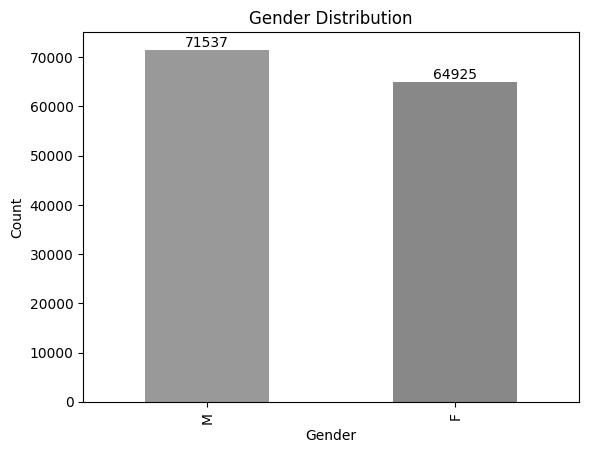

In [79]:
# Count the occurrences of each gender
gender_counts = data_df.gender.value_counts()

# Create a bar plot with labels
fig, ax = plt.subplots()
gender_counts.plot(kind='bar', color=['#999999', '#888888', '#777777', '#666666', '#555555', '#444444', '#333333'], ax=ax)

# Add labels
for i, v in enumerate(gender_counts):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# Show the plot
plt.show()


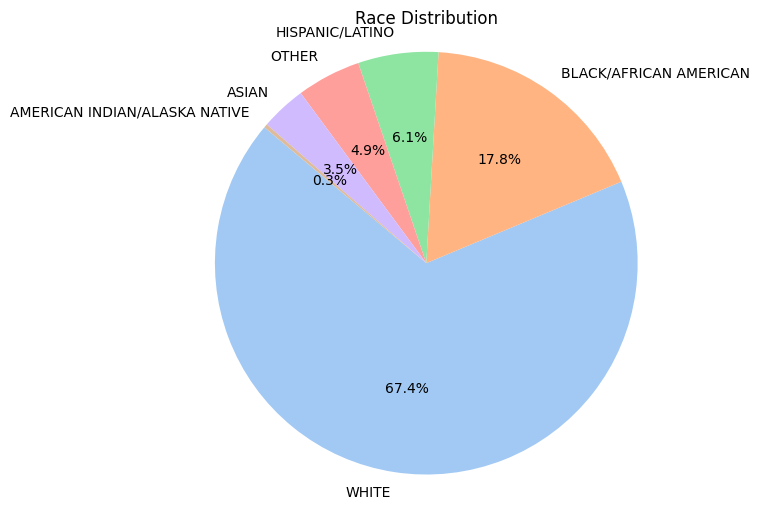

In [80]:
# Count the occurrences of each race
race_counts = data_df.race.value_counts()

# Define a Seaborn color palette with muted colors
sns.set_palette("pastel")

# Create a pie chart using Seaborn
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.pie(race_counts, labels=race_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Race Distribution')

# Show the pie chart
plt.axis('equal')
plt.show()

C:\Users\gebre\AppData\Local\Temp\ipykernel_17656\1176276377.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_df, x='age_decile', palette="pastel")


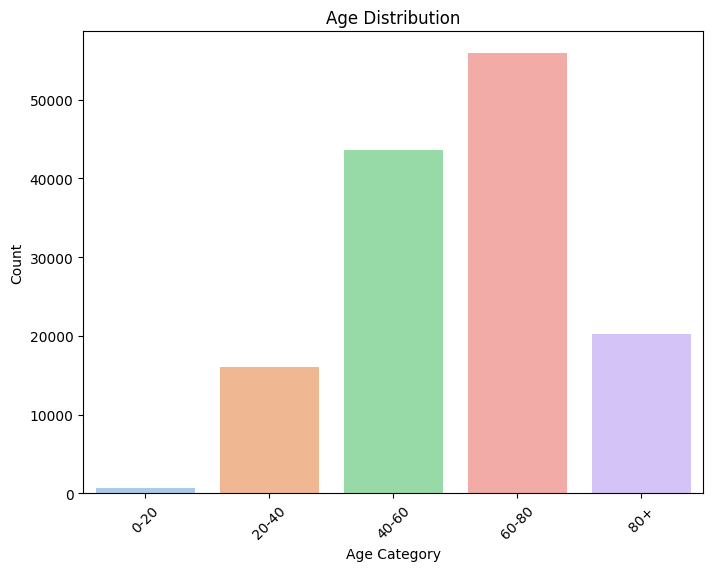

In [81]:
# Set a Seaborn style with muted colors
sns.set_palette("pastel")

# Create a count plot for age categories
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.countplot(data=data_df, x='age_decile', palette="pastel")
plt.title('Age Distribution')
plt.xlabel('Age Category')
plt.ylabel('Count')

# Show the count plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

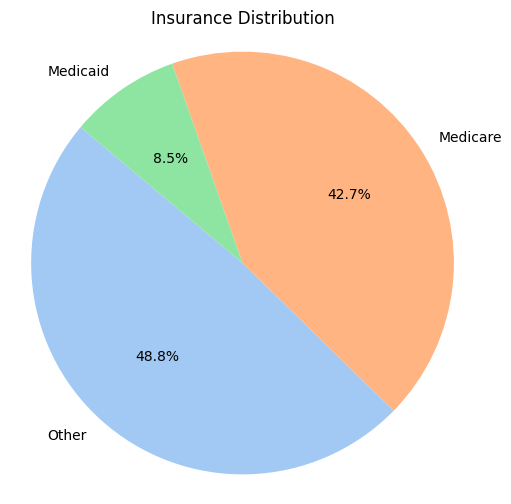

In [82]:
# Count the occurrences of each insurance
insurance_counts = data_df.insurance.value_counts()

# Define a Seaborn color palette with muted colors
sns.set_palette("pastel")

# Create a pie chart using Seaborn
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
plt.pie(insurance_counts, labels=insurance_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Insurance Distribution')

# Show the pie chart
plt.axis('equal')
plt.show()